Decision for Project:

Math Teacher (M1) and Student (X2) and Schools Types

Process:
Correlation between the age/qualification of the teacher and the grades/progress of the students
M1STARTDEG
M1MATHJOB
M1CERT912
M1TEACHING
M1ACHIEVE



student :(Gpa of math)

Group to reduce data size:
Characteristics: X1SEX(2),X1WHITE(2),X1BLACK(2),X1HISPANIC(2),
     X1CONTROL,X1LOCALE,X1REGION,X1SES (SOC-ECO)
     M1TEACHING(3),M1LEARNING(3)
     M1CERT68(2),M1CERT912(2),
     X1TMEFF,X1MTHEFF(),X1TXMQUINT(5),
      X3THIMATH9 #freshmen yr response in 2013

S2AFF4YOUT,S2AFF4YIN,S2AFF2YPUB,S2AFF4YPRV

Results: X3TGPAHIMTH(),,X3PROGLEVEL, X3THIMATH(14 SEE CHART) #2013 senior yr
X3TCREDAPMTH(x4 for real credit)


#visualization

1. Scatterplot
2. LinReg (multiple attr include school types, teacher Qual)
3. Decision Tree
4. Prediction (student grade after changing teacher)

Things to do:
1. A heat map over US map to visualize the distribution of schools over US.
Few hypothesis that I intend to test:
1. Difference in self science efficacy over gender,
2. Difference in self science efficacy over race, socio econmic status
3. School Region


In [2]:
#@title Google Drive Sync (Do NOT Delete)
from google.colab import drive
drive.mount('/content/gdrive')
%cd gdrive/My\ Drive/ECE\ 143\ Project/Dataset/
#add the route path on your own below

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).
[Errno 2] No such file or directory: 'gdrive/My Drive/ECE 143 Project/Dataset/'
/content/gdrive/My Drive/ECE 143 Project/Dataset


In [0]:
#@title Example fields
#@markdown Forms support many types of fields.

#no_type_checking = ''  #@param
#string_type = 'example'  #@param {type: "string"}
#slider_value = 105  #@param {type: "slider", min: 100, max: 200}
#number = 102  #@param {type: "number"}
#date = '2010-11-05'  #@param {type: "date"}
#pick_me = "monday"  #@param ['monday', 'tuesday', 'wednesday', 'thursday']
#select_or_input = "apples" #@param ["apples", "bananas", "oranges"] {allow-input: true}
#@markdown ---


Columns to keep

---


S2AFF4YIN
S2AFF4YOUT
X1TXMQUINT



In [0]:
#@title Import Data
%%time
%pylab inline
%load_ext google.colab.data_table
import numpy as np
import pandas as pd
import math
import pickle
import matplotlib.pyplot as plt
from scipy import stats
import time
from collections import Counter
from IPython.core.interactiveshell import InteractiveShell
from IPython.display import display
InteractiveShell.ast_node_interactivity = "all"
pd.options.display.max_columns = 50 #None
plt.rcParams["figure.figsize"] = (10,10) #Resize image size

# from multiprocessing import Pool,cpu_count
# from pandarallel import pandarallel
# !pip install pandarallel
# # Initialization
# pandarallel.initialize(progress_bar=True)
#data here
sc=pd.read_csv('hsls_school_v1_0.csv').iloc[:,0:476]
st=pd.read_csv('hsls_student_v1_0.csv').iloc[:,0:3579]
#st=st.drop(columns=['X1RACE','X1HISPANIC','X1BLACK'])

#remove -5 values, private data
sc=sc.replace(-5,np.nan)
st=st.replace(-5,np.nan)
sc=sc.dropna(axis=1)
st=st.dropna(axis=1)

#Remove invalid datat
sc=sc.replace([-9,-8,-7],np.nan)
st=st.replace([-9,-8,-7],np.nan)
#Replace NA with minimum value in that column
sc=sc.fillna(sc.min(axis=0))
st=st.fillna(st.min(axis=0))
print('Finish Cleaning')
#Categorize
st_x1=st.filter(regex='^X1',axis=1)
st_x2=st.filter(regex='^X2',axis=1)
st_x3=st.filter(regex='^X3',axis=1)
st_x4=st.filter(regex='^X4',axis=1)
st_s1=st.filter(regex='^S1',axis=1)
st_s2=st.filter(regex='^S2',axis=1)
st_s3=st.filter(regex='^S3',axis=1)
st_s4=st.filter(regex='^S4',axis=1)
st_p1=st.filter(regex='^P1',axis=1) #Parent
st_p2=st.filter(regex='^P2',axis=1) #Parent 2
st_m1=st.filter(regex='^M1',axis=1) #Math Teacher
st_n1=st.filter(regex='^N1',axis=1) #Science Teacher
st_a1=st.filter(regex='^A1',axis=1) #Administration
st_a2=st.filter(regex='^A2',axis=1) #Administration 2
st_c1=st.filter(regex='^C1',axis=1) #Counselor
st_c2=st.filter(regex='^C2',axis=1) #Counselor 2
sc_x1=sc.filter(regex='^X1',axis=1) #KEEP, X1REGION,X1LOCALE
sc_a1=sc.filter(regex='^A1',axis=1) #KEEP
sc_c1=sc.filter(regex='^C1',axis=1)
st_gpa=st.filter(regex='X3TGPA',axis=1)
print("Finish")

Populating the interactive namespace from numpy and matplotlib


{1, 2, 3, 4}


Text(0, 0.5, 'Count')

Text(0.5, 1.0, 'School System by Region')

([<matplotlib.axis.XTick at 0x7ff8c4f35908>,
 <a list of 4 Text xticklabel objects>)

([<matplotlib.axis.YTick at 0x7ff8c4f31668>,
 <a list of 9 Text yticklabel objects>)

Text(0, 0.5, 'Count')

Text(0.5, 1.0, 'School Urbanicity By Region')

([<matplotlib.axis.XTick at 0x7ff8c5405198>,
 <a list of 4 Text xticklabel objects>)

([<matplotlib.axis.YTick at 0x7ff8c5405eb8>,
 <a list of 5 Text yticklabel objects>)

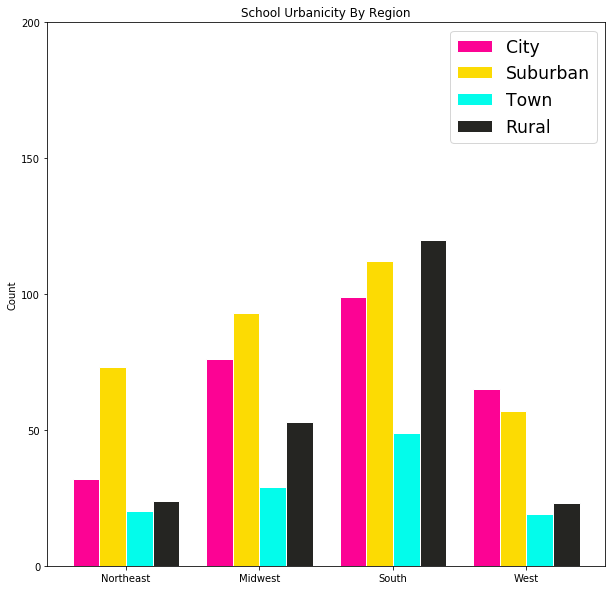

In [0]:
#@title Region Graphs
print(set(list(sc_x1['X1REGION']))) #Northeast, Midwest, South, West
r_pu=[] #public
r_pr=[] #private
r_c=[] #city
r_s=[] #suburban
r_t=[] #town
r_r=[] #rural
#Ref: https://nces.ed.gov/programs/edge/docs/LOCALE_CLASSIFICATIONS.pdf
for i in [1,2,3,4]: #region
    r_pu.append(len(sc.query('X1REGION==%d and X1CONTROL==1' %(i))))
    r_pr.append(len(sc.query('X1REGION==%d and X1CONTROL==2' %(i))))
    r_c.append(len(sc.query('X1REGION==%d and X1LOCALE==1' %(i))))
    r_s.append(len(sc.query('X1REGION==%d and X1LOCALE==2' %(i))))
    r_t.append(len(sc.query('X1REGION==%d and X1LOCALE==3' %(i))))
    r_r.append(len(sc.query('X1REGION==%d and X1LOCALE==4' %(i))))
    

# print(r_pu)
# print(r_pr)
# print(r_u)
# print(r_s)
# print(r_t)
# print(r_r)
bar1=[1,2,3,4]
barwidth=0.4
p1=plt.bar(bar1,r_pu,color='#fca103',
           width=barwidth,edgecolor='white',label='Public')
p2=plt.bar([x + barwidth for x in bar1],r_pr,color='#20fc03',
           width=barwidth,edgecolor='white',label='Private')
plt.ylabel("Count")
plt.title('School System by Region')
plt.xticks([x + barwidth*0.5 for x in bar1],('Northeast','Midwest','South','West'))
plt.yticks(np.arange(0,401,50))
plt.legend((p1[0],p2[0]),('Public','Private'),fontsize='xx-large')
plt.savefig(r"School_Type.png")
plt.show()

#s_region=pd.DataFrame.from_dict(n_c, orient='index')
#df.plot(kind='bar')
#plt.bar(c_region.keys(), c_region.values(), color='g',tick_label=['South','Midwest', 'West','Northeast'])
#plt.title("School Region Distribution")

barwidth=0.2
r1=plt.bar(bar1,r_c,color='#fc0394',
            width=barwidth,edgecolor='white',label='Northeast')
r2=plt.bar([x + barwidth for x in bar1],r_s,color='#fcdb03',
            width=barwidth,edgecolor='white',label='Midwest')
r3=plt.bar([x + barwidth*2 for x in bar1],r_t,color='#03fceb',
            width=barwidth,edgecolor='white',label='South')
r4=plt.bar([x + barwidth*3 for x in bar1],r_r,color='#252522',
            width=barwidth,edgecolor='white',label='West')

plt.ylabel("Count")
plt.title('School Urbanicity By Region')
plt.xticks([x + barwidth*1.5 for x in bar1],('Northeast','Midwest','South','West'))
plt.yticks(np.arange(0,250,50))
plt.legend((r1[0],r2[0],r3[0],r4[0]),('City','Suburban','Town','Rural'),fontsize='xx-large')
plt.savefig("School_Region.png")
plt.show()

In [0]:
print(sum(r_pu)/(sum(r_pu)+sum(r_pr)))
t=[]
for i in range(len(r_pu)):
    t.append(r_pr[i]+r_pu[i])
print((sum(r_pu)+sum(r_pr)))

0.8125
944


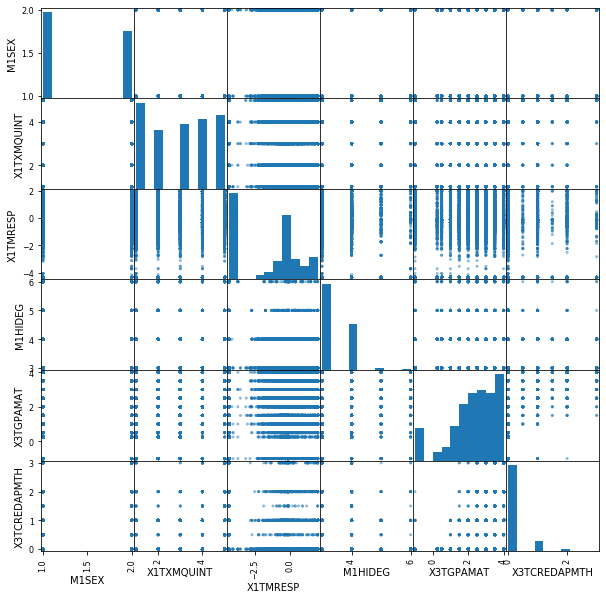

In [0]:
t=pd.plotting.scatter_matrix(st.loc[:,['M1SEX','X1TXMQUINT','X1TMRESP','M1HIDEG','X3TGPAMAT','X3TCREDAPMTH']])
plt.savefig(r"figure_1.png")

In [0]:
#@title Category to Dummy
#sc_x1=pd.get_dummies(sc_x1, columns=['X1CONTROL','X1LOCALE','X1REGION'],drop_first=False,dummy_na=False, dtype=int)
sc_x1=sc_x1.rename(columns={"X1CONTROL_1": "Public", "X1CONTROL_2": "Private",
                            "X1LOCALE_1": "Urban", "X1LOCALE_2": "Suburban","X1LOCALE_3": "Rural",
                            "X1REGION_1": "Northwest","X1REGION_2":"Midwest",
                            "X1REGION_3":'South',"X1REGION_4":'West'})

print(st_x1)


In [0]:
pd.set_option('display.width', None)
pd.set_option('display.max_colwidth', -1)


In [0]:
b=np.sum(st_m['Black'])
w=np.sum(st_m['White'])
h=np.sum(st_m['Hispanic'])
print(b+w+h)

24566.0


/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:4238: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().rename(**kwargs)
/usr/local/lib/python3.6/dist-packages/pandas/core/generic.py:6786: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._update_inplace(new_data)
/usr/local/lib/python3.6/dist-packages/pandas/core/generic.py:6702: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-vie

Text(0.5, 1.0, 'White Students Distribution By Region and Locality')

Text(0.5, 1.0, 'Black Students Distribution By Region and Locality')

Text(0.5, 1.0, 'Hispanic Students Distribution By Region and Locality')

Text(0.5, 1.0, 'Minority Students Distribution By Region and Locality')

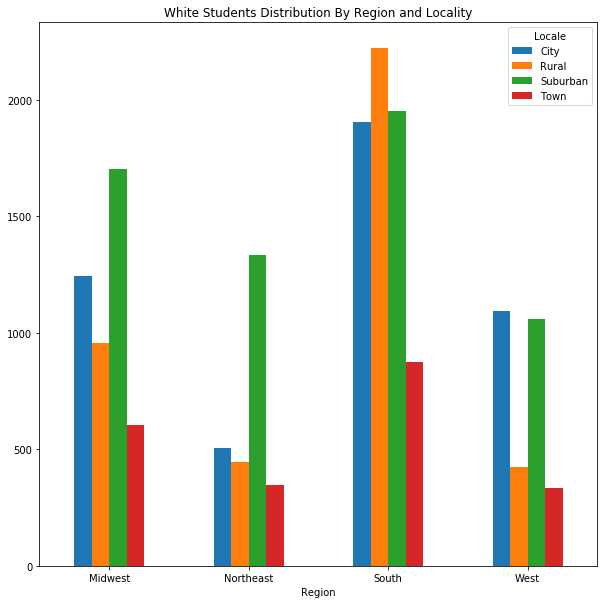

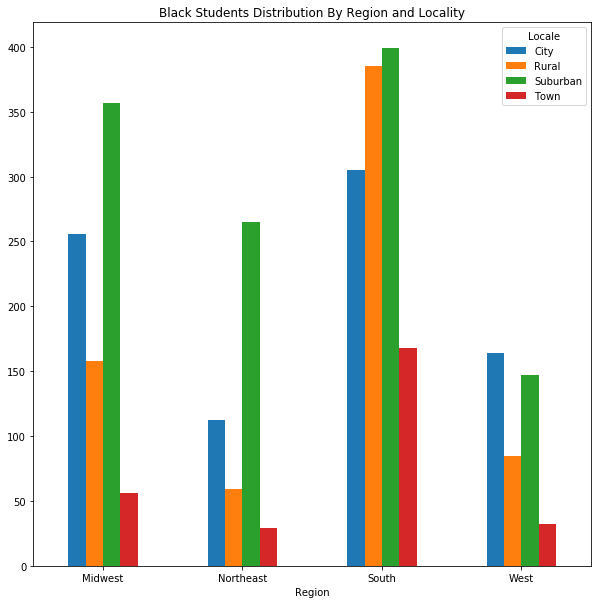

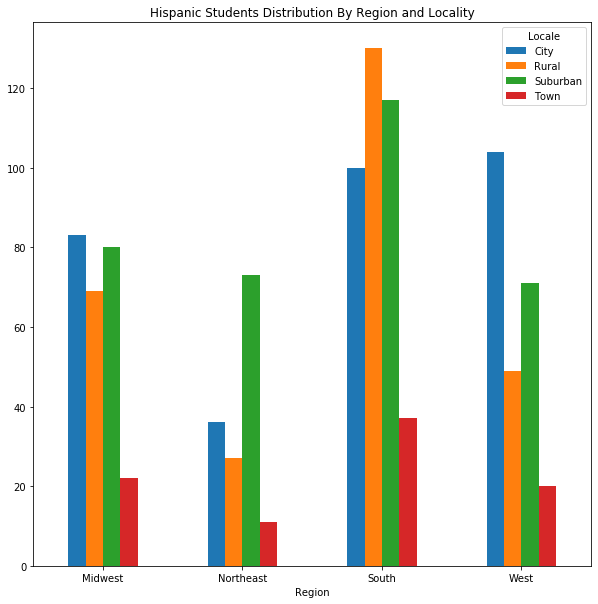

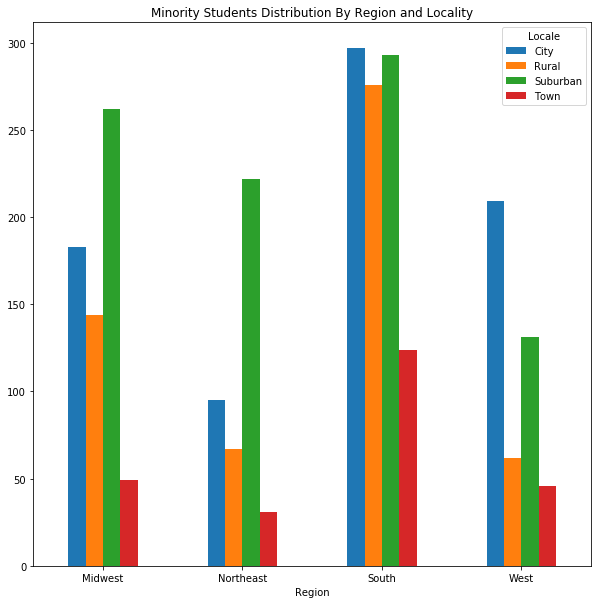

In [0]:
#@title Math Analysis Begin 
st_m=st[['X1SEX','X1WHITE','X1BLACK','X1HISPANIC', #predictor
    'X1CONTROL','X1LOCALE','X1REGION','X1SES','M1TEACHING','M1LEARNING', #predictor
    'M1CERT68','M1CERT912','X1TMEFF','X1MTHEFF','X1TXMQUINT', #predictor
    'X3THIMATH9','S2AFF4YOUT','S2AFF4YIN','S2AFF2YPUB','S2AFF4YPRV', #predictor
    'X3TGPAHIMTH','X3PROGLEVEL','X3THIMATH']] #result of student math level
#st_x1=pd.get_dummies(st_x1,columns=['X1SEX'],dummy_na=False,drop_first=True,dtype=int)
st_m.rename(columns={"X1LOCALE": "Locale","X1REGION":"Region",'X1CONTROL':'Type',
                          'X1SEX':'Sex','X1WHITE':'White','X1BLACK':'Black','X1HISPANIC':'Hispanic',
                          'X1SES':'Social-Eco','M1TEACHING':'High Teaching Std','M1LEARNING':'High Learning Std',
                          'M1CERT68':'Certify in 6-8','M1CERT912':'Certify in 9-12',
                          'X1TMEFF':'Math Teacher Efficacy','X1MTHEFF':'Student Math Efficacy',  
                          'X1TXMQUINT':'Math Quintile','X3THIMATH9':'Highest Math in 9',
                          'S2AFF4YOUT':'Out State Afford','S2AFF4YIN':'In State Afford',
                          'S2AFF2YPUB':'Community Afford','S2AFF4YPRV':'Private Afford',
                          'X3TGPAHIMTH':'GPA of Highest Math','X3PROGLEVEL':'Degree Level', 'X3THIMATH':'Highest Math Course'},inplace=True)

st_m['Type'].replace(2,"Private",inplace=True)
st_m['Type'].replace(1,"Public",inplace=True)
st_m['Sex'].replace(1,'M',inplace=True)
st_m['Sex'].replace(2,'F',inplace=True)
st_m.replace({'Region':{1:'Northeast',2:'Midwest',3:'South',4:'West'}},inplace=True)
st_m.replace({'Locale':{1:'City',2:'Suburban',3:'Town',4:'Rural'}},inplace=True)
st_m[(st_m['White']==1)].groupby(['Region','Locale'])['Black'].count().unstack().plot(kind='bar',rot=0,label='Region') #to_frame().reset_index()
plt.title('White Students Distribution By Region and Locality')
plt.savefig("W_dist.png")

st_m[(st_m['White']!=1)&(st_m['Black']==1)].groupby(['Region','Locale'])['Black'].count().unstack().plot(kind='bar',rot=0,label='Region') #to_frame().reset_index()
plt.title('Black Students Distribution By Region and Locality')
plt.savefig("B_dist.png")

st_m[(st_m['White']!=1)&(st_m['Black']!=1)&(st_m['Hispanic']==1)].groupby(['Region','Locale'])['Black'].count().unstack().plot(kind='bar',rot=0,label='Region') #to_frame().reset_index()
plt.title('Hispanic Students Distribution By Region and Locality')
plt.savefig("H_dist.png")

st_m[(st_m['White']!=1)&(st_m['Black']!=1)&(st_m['Hispanic']!=1)].groupby(['Region','Locale'])['Black'].count().unstack().plot(kind='bar',rot=0,label='Region') #to_frame().reset_index()
plt.title('Minority Students Distribution By Region and Locality')
plt.savefig("M_dist.png")




#st[(st['X1WHITE']!=1)&(st['X1BLACK']!=1)].groupby(['X1REGION','X1LOCALE'])['X1HISPANIC'].count().unstack().plot(kind='bar',rot=0) #to_frame().reset_index()
#st[(st['X1WHITE']!=1)&(st['X1BLACK']!=1)].groupby(['X1REGION','X1LOCALE'])['X1HISPANIC'].count().unstack().plot(kind='bar',rot=0) #to_frame().reset_index()

# st.groupby(['X1REGION','X1LOCALE'])['X1WHITE'].count().unstack().plot(kind='bar',rot=0) #to_frame().reset_index()
# st.groupby(['X1REGION','X1LOCALE'])['X1WHITE'].count().unstack().plot(kind='bar') #to_frame().reset_index()

# fig, ax = plt.subplots()
# st['X1REGION'].hist(by=st[st['X1WHITE']==1]['X1WHITE'], ax=ax,)
# (st['X1REGION']+0.1).hist(by=st[st['X1WHITE']==0]['X1WHITE'], ax=ax)
# print(ax)
#st['X1LOCALE']


In [0]:
#@title Notes
# def make_na(df,col,val):
#     '''
#     Replace value in df to np.nan
#     df:dataframe
#     col:columns name, list of str
#     val: values to replace,must be list
#     '''
#     assert isinstance(df,pd.DataFrame)
#     assert isinstance(col,list)
#     for i in range(len(col)):
#         isinstance(col[i],str)
#     assert isinstance(val,list)

#     i=0
#     for i in range(df.shape[0]):
#         for j in col:
#             if(df.loc[i,j] in val):
#                 df.loc[i,j]=np.nan

#     return df

#df=parallelize_dataframe(df,make_na)
# def parallelize_dataframe(df, func, n_cores=cpu_count()):
#     df_split = np.array_split(df, n_cores)
#     pool = Pool(n_cores)
#     df = pd.concat(pool.map(func, df_split))
#     pool.close()
#     pool.join()
#     return df

In [0]:
%%time

#st_x1=parallelize_dataframe(st_x1,make_na,['X1SCIID'],[-9,-8]))
#st_x1=make_na(st_x1,['X1SCIID'],[-9.,-8.])

CPU times: user 2 µs, sys: 1 µs, total: 3 µs
Wall time: 4.77 µs


Dependence of Student-level variables on self science-efficacy

 Student Sex : X1SEX 1 = 'MALE' and 2 = 'FEMALE'
 Student Race : X1RACE
 Student's Science Courses

In [0]:
df = st[['STU_ID','X1SEX','X1SES', 'X1RACE','X1SCIEFF','X4REGION']]
df = df.astype({'X1SEX' : 'category','X1RACE': 'category','X4REGION':'category' })
df.dropna(inplace=True)
print(len(df))

23503


In [0]:
print("Science self-efficacy statistics")
df.X1SCIEFF.describe()
print('\nSocioeconomic status statistics')
df.X1SES.describe()
print("Student Race Statistics")
df.X1RACE.describe()
df.X1RACE.unique()
print("Student Sex Statistics")
df.X1SEX.describe()
df.X1SEX.unique()


print("Student Region Statistics")
df.X4REGION.unique()

Science self-efficacy statistics


count    23503.000000
mean        -0.745154
std          1.557514
min         -2.910000
25%         -2.910000
50%         -0.360000
75%          0.250000
max          1.830000
Name: X1SCIEFF, dtype: float64


Socioeconomic status statistics


count    23503.000000
mean        -0.119742
std          0.932881
min         -1.930200
25%         -0.666500
50%         -0.102700
75%          0.493850
max          2.880700
Name: X1SES, dtype: float64

Student Race Statistics


count     23503.0
unique        8.0
top           8.0
freq      12082.0
Name: X1RACE, dtype: float64

[8.0, 3.0, 5.0, 2.0, 1.0, 6.0, 4.0, 7.0]
Categories (8, float64): [8.0, 3.0, 5.0, 2.0, 1.0, 6.0, 4.0, 7.0]

Student Sex Statistics


count     23503.0
unique        2.0
top           1.0
freq      11979.0
Name: X1SEX, dtype: float64

[1.0, 2.0]
Categories (2, float64): [1.0, 2.0]

Student Region Statistics


[2.0, 1.0, 4.0, 3.0]
Categories (4, float64): [2.0, 1.0, 4.0, 3.0]

In [0]:
## Import the packages
import numpy as np
from scipy import stats


cat1 = df[df['X1SEX']==1.0]
cat2 = df[df['X1SEX']==2.0]

print("t-test results for diff in scieff between male and female")
stats.ttest_ind(cat1['X1SCIEFF'], cat2['X1SCIEFF'],equal_var=False)

cat1 = df[df.X4REGION==1.0]
cat2 = df[df.X4REGION!=1.0]
# cat1.describe();
# cat2.describe();
print("\n\n t-test results for diff in scieff between public school students and others")
print(stats.ttest_ind(cat1['X1SCIEFF'], cat2['X1SCIEFF'], equal_var=False))
cat1['X1SES'].describe()
cat2['X1SES'].describe()


print('\n\n t-test statistics for diff in SES for public students and others')
print(stats.ttest_ind(cat1['X1SES'], cat2['X1SES'], equal_var=False))




# Pearson Correlation between SES and SCIEFF
from scipy.stats import pearsonr
a,_ = pearsonr(df.X1SES,df.X1SCIEFF);
print('Correlation between SES and SCIEFF: ', a)
from matplotlib import pyplot as plt
plt.plot(df.X1SES, df.X1SCIEFF,'o')
plt.show()

t-test results for diff in scieff between male and female


Ttest_indResult(statistic=4.1765290775305255, pvalue=2.97060019719864e-05)



 t-test results for diff in scieff between public school students and others
Ttest_indResult(statistic=-4.715586622286948, pvalue=2.42715155307325e-06)


count    9043.000000
mean       -0.188522
std         0.912192
min        -1.930200
25%        -0.720850
50%        -0.159500
75%         0.417000
max         2.880700
Name: X1SES, dtype: float64

count    14460.000000
mean        -0.076727
std          0.943075
min         -1.930200
25%         -0.635200
50%         -0.067450
75%          0.553700
max          2.566800
Name: X1SES, dtype: float64



 t-test statistics for diff in SES for public students and others
Ttest_indResult(statistic=-9.022691917824217, pvalue=2.0001276362691945e-19)
Correlation between SES and SCIEFF:  0.4073694318254276


In [0]:
# Shreyas - Working on different visualisation on maps
# Potential linear regression/curve fitting model for some of the correlated variables - Ye t to decide which variables. 